# <font color='green'>Projet Spark Core </font> <font color='red'>  © </font>

#### 4IABD3 - 2021-2022

### <font color='blue'> Groupe 5 </font>
Membres du groupe :

- BOUAZIZ Malika 
- BOUAZIZ Rima
- MIGAN DASSI Bayode Seth


### <font color='green'> Ecole superieure de génie informatique  (ESGI)</font>

# <font color='blue'> Projet spark core  visualisation des données relatives aux puits d'eau en Tanzani </font>




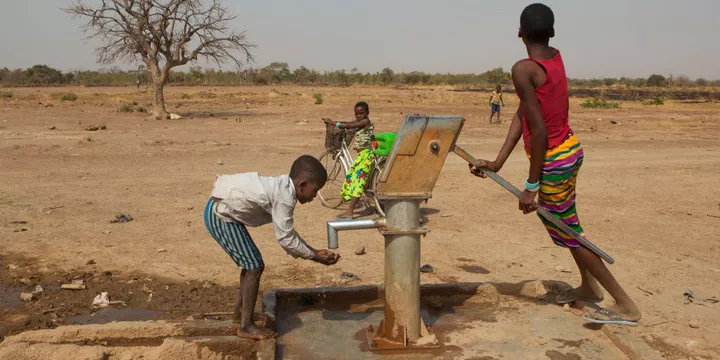

In [1]:
from IPython.core.display import Image, display
display(Image('https://www.francetvinfo.fr/pictures/H-v1UMtJDRO3OszDkqZFEONfLZ0/fit-in/720x/filters:format(webp)/2018/11/27/Des-enfants-pr-s-d-un-puits-dans-village-au-Burkina-Faso_0.jpg', width=900, unconfined=True))

# **Problématique** 

L'eau c'est la vie. Elle joue un rôle primordial dans la vie des hommes, des animaux et des plantes. C'est le principal constituant des êtres vivants et il est indispensable à toute forme de vie, sans eau aucun organisme qu'il soit végétal ou animal, simple ou complexe petit ou gros ne peut vivre. En faisant une recherche sur les pays les plus pauvres en sources d'eaux, on est tombé sur la Tanzanie qui fait partie des pays avec une forte croissance de la population mais qui souffre à cause du manque d'eau potable ( une maladie sur neuf est due à la mauvaise qualité d'eau). Notre étude consiste à mettre en avant les puits d'eaux et leur répartition ainsi que le type ( défectueux , opérationnels, abandonnés ... ) afin d'aider à mieux les exploiter et améliorer les services d'eau dans ce pays

### installation et importation des libraries

In [2]:
!pip install -q findspark

In [3]:
!pip install pyspark

In [4]:
from google.colab import files
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import isnan, when, count, col, lit, trim, avg, ceil, sum, max, min, avg, row_number
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import folium 

### importation des datasets

In [5]:
#le premier data set contient les caractéristiques décrivant les puits
!wget https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv -O features.csv
#le 2eme data set contient les étiquettes décrivant l'état des puits
!wget https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv -O labels.csv

--2022-02-10 00:53:25--  https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.19.157
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.19.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20069199 (19M) [text/csv]
Saving to: ‘features.csv’

features.csv        100%[===================>]  19.14M  3.72MB/s    in 12s     

2022-02-10 00:53:38 (1.56 MB/s) - ‘features.csv’ saved [20069199/20069199]

--2022-02-10 00:53:38--  https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.106.93
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.106.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148327 (1.1M) [text/csv]
Saving to: ‘labels.csv’

labels.csv          100%[===================>]   1.09M  1013KB/s    in 1.1s    

2022-02-10 00:53:40 (1013 KB/s

In [6]:
!ls # confirmer qu'on a bien telecharger les dataset

features.csv  population_well_total_per_region.png  show_gps_height.png
labels.csv    sample_data


In [7]:
#création d'une spark session
sc = SparkSession.builder.master("local[*]").getOrCreate()

In [8]:
feature = sc.read.csv("features.csv", inferSchema=True, header=True)
label = sc.read.csv("labels.csv", inferSchema=True, header=True)


In [9]:
print(feature.count())
print(label.count())
feature.printSchema()
label.printSchema()


59400
59400
root
 |-- id: integer (nullable = true)
 |-- amount_tsh: double (nullable = true)
 |-- date_recorded: string (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: integer (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: integer (nullable = true)
 |-- district_code: integer (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: boolean (nullable = true)
 |-- recorded_by: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: boolean (nullable = true)
 |-- construction_year: integer 

on remarquera qu'il y a 59 400 lignes dans chaque fichier et label dataset contient une colonne appelée 'status_groupe', qui contient
l'état des puits

Les deux fichiers contiennent une colonne appelée ID, qu'on utilisera 
pour fusionner les fichiers. Pour fusionner les deux ensembles de données, on  utilisera
la fonction join(). 
on pourra  confirmer les noms de colonne
et le nombre de lignes dans l'ensemble de données fusionnées.

In [10]:
data = feature.join(label, on = ("id") ) 
print(data.count())
data.printSchema()


59400
root
 |-- id: integer (nullable = true)
 |-- amount_tsh: double (nullable = true)
 |-- date_recorded: string (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: integer (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: integer (nullable = true)
 |-- district_code: integer (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: boolean (nullable = true)
 |-- recorded_by: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: boolean (nullable = true)
 |-- construction_year: integer (nulla

## Affichage des 10 premieres lignes du Dataframe

In [11]:
data.show(n=10)

+-----+----------+-------------+-------------------+----------+------------+-----------+------------+--------------------+-----------+--------------------+---------------+---------+-----------+-------------+---------------+----------+----------+--------------+--------------------+-----------------+--------------------+------+-----------------+---------------+---------------------+---------------------+----------+----------------+--------------+------------+-------------+-------------+------------+--------------+--------------------+--------------------+------------+--------------------+---------------------+--------------+
|   id|amount_tsh|date_recorded|             funder|gps_height|   installer|  longitude|    latitude|            wpt_name|num_private|               basin|     subvillage|   region|region_code|district_code|            lga|      ward|population|public_meeting|         recorded_by|scheme_management|         scheme_name|permit|construction_year|extraction_type|extracti

vous remarquerez ce region_code
et le district_code contient des valeurs numériques,
mais ces colonnes doivent être traitées comme catégorielles
car les valeurs numériques lui donneront un poids incorrect
lors d'un processus de modélisation d'apprentissage automatique. on va changer 
ces colonnes au type de chaîne en utilisant le withColumn() et
Fonctions StringType()

In [12]:
# La fonction withColumn prend deux arguments -le nom de la nouvelle colonne et l'expression de la nouvelle colonne
data = data.withColumn('region_code', col('region_code').cast(StringType())).withColumn('district_code', col('district_code').cast(StringType()))

In [13]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- amount_tsh: double (nullable = true)
 |-- date_recorded: string (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: integer (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: string (nullable = true)
 |-- district_code: string (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: boolean (nullable = true)
 |-- recorded_by: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: boolean (nullable = true)
 |-- construction_year: integer (nullable = tr

## Supprimer les lignes qui sont en doublons

In [14]:
data=data.dropDuplicates(["id"])
data.count()

59400

y a pas de data dupliquées d'ou le fait qu'on a le meme nombre de lignes

en utilisant la fonction trim(), on peut supprimer les espaces blancs dans chaque
de ces colonnes.

In [15]:
str_cols = [item[0] for item in data.dtypes if item[1].startswith('string')]
for cols in str_cols:
  data= data.withColumn(cols, trim(data[cols]))

## supprimer les colonnes avec les valeurs nulles a partir d'un certain seuil 

In [16]:
data.select([count(when(isnan(c) | col(c).isNull(),c  )).alias(c) for c in data.columns if c not in {'date_recorded', 'public_meeting','permit' } ]).show()

+---+----------+------+----------+---------+---------+--------+--------+-----------+-----+----------+------+-----------+-------------+---+----+----------+-----------+-----------------+-----------+-----------------+---------------+---------------------+---------------------+----------+----------------+-------+------------+-------------+-------------+--------+--------------+------+-----------+------------+---------------+---------------------+------------+
| id|amount_tsh|funder|gps_height|installer|longitude|latitude|wpt_name|num_private|basin|subvillage|region|region_code|district_code|lga|ward|population|recorded_by|scheme_management|scheme_name|construction_year|extraction_type|extraction_type_group|extraction_type_class|management|management_group|payment|payment_type|water_quality|quality_group|quantity|quantity_group|source|source_type|source_class|waterpoint_type|waterpoint_type_group|status_group|
+---+----------+------+----------+---------+---------+--------+--------+----------

ça affiche chaque colonne et le nombre de valeurs null qu'elle contient 

Et on remarquera  que la colonne "scheme_name" a
28 000 valeurs nulles, soit plus de 40 % des valeurs totales
dans cette colonne.
Mais au lieu de parcourir manuellement chaque valeur et de décider
s'il faut conserver ou supprimer la colonne, nous pouvons définir un seuil
valeur au-delà de laquelle une colonne peut être supprimée.
Nous allons modifier la cellule actuelle et obtenir le nombre moyen
de valeurs nulles dans une variable.

In [17]:
agg_row= data.select([(count(when(isnan(c) | col(c).isNull(),c  ))/data.count()).alias(c) for c in data.columns if c not in {'date_recorded', 'public_meeting','permit' } ]).collect()

In [18]:
#convertir le résultat dans un dictionnaire pour une itération facile

agg_dict_list =[row.asDict() for row in agg_row]
agg_dict= agg_dict_list[0]

In [19]:
#on itére sur ce dictionnaire et stocke les noms de colonnes, qui ont nombre moyen de valeurs nulles plus qu'un seuil donné
#on a choisit 0.4 par rapport aux 40% 
col_null = list({i for i in agg_dict if agg_dict[i] > 0.4 })
print(agg_dict)
print(col_null)
data = data.drop(*col_null)

{'id': 0.0, 'amount_tsh': 0.0, 'funder': 0.0611952861952862, 'gps_height': 0.0, 'installer': 0.061531986531986535, 'longitude': 0.0, 'latitude': 0.0, 'wpt_name': 0.0, 'num_private': 0.0, 'basin': 0.0, 'subvillage': 0.0062457912457912455, 'region': 0.0, 'region_code': 0.0, 'district_code': 0.0, 'lga': 0.0, 'ward': 0.0, 'population': 0.0, 'recorded_by': 0.0, 'scheme_management': 0.06526936026936027, 'scheme_name': 0.4741750841750842, 'construction_year': 0.0, 'extraction_type': 0.0, 'extraction_type_group': 0.0, 'extraction_type_class': 0.0, 'management': 0.0, 'management_group': 0.0, 'payment': 0.0, 'payment_type': 0.0, 'water_quality': 0.0, 'quality_group': 0.0, 'quantity': 0.0, 'quantity_group': 0.0, 'source': 0.0, 'source_type': 0.0, 'source_class': 0.0, 'waterpoint_type': 0.0, 'waterpoint_type_group': 0.0, 'status_group': 0.0}
['scheme_name']


dans chaque colonne on a la moyenne des val null 

et le col_null contient scheme_name cest la colonne qu'on veut supprimer 

# Group, aggregate, creer un  pivot_table.

In [20]:
#count utilise l'ordre asc 
data.groupBy('recorded_by').count().show()

+--------------------+-----+
|         recorded_by|count|
+--------------------+-----+
|GeoData Consultan...|59400|
+--------------------+-----+



comme on peut remarquer cette colonne contient seulement "GeoData Consultants Ltd" dupliqué dans tout les lignes

on essaye de voir avec une autre colonne

In [21]:
data.groupBy('water_quality').count().orderBy('count', ascending= False).show()

+------------------+-----+
|     water_quality|count|
+------------------+-----+
|              soft|50818|
|             salty| 4856|
|           unknown| 1876|
|             milky|  804|
|          coloured|  490|
|   salty abandoned|  339|
|          fluoride|  200|
|fluoride abandoned|   17|
+------------------+-----+



on déduit que la colonne recroded_by n'est pas informative donc elle peut etre supprimé

In [22]:
data = data.drop('recorded_by')

## creation d'un pivot_table grouped by statut des puits dans chaque region et calculer la somme de la quantité totale d'eau dans les puits

#### pivot_table() évite la répétition des données de la DataFrame . Elle résume les données et applique différentes fonctions d'agrégation sur les données.

In [23]:
data.groupBy('status_group').pivot('region').sum('amount_tsh').show()

+--------------------+---------+-------------+------+---------+------+--------+------------------+-------+--------+--------+-----+--------+-------+-------+---------+--------+---------+---------+--------+------+--------+
|        status_group|   Arusha|Dar es Salaam|Dodoma|   Iringa|Kagera|  Kigoma|       Kilimanjaro|  Lindi| Manyara|    Mara|Mbeya|Morogoro| Mtwara| Mwanza|    Pwani|   Rukwa|   Ruvuma|Shinyanga| Singida|Tabora|   Tanga|
+--------------------+---------+-------------+------+---------+------+--------+------------------+-------+--------+--------+-----+--------+-------+-------+---------+--------+---------+---------+--------+------+--------+
|functional needs ...|  10280.0|          0.0|   0.0| 118400.0|   0.0|270770.0|          129248.0| 3625.0| 71315.0|   900.0|  0.0| 70005.0|36240.0|10000.0|    520.0|292980.0| 125650.0|   2200.0|  6505.0|   0.0|  4310.0|
|          functional|1125485.0|     181175.0|   0.0|5515710.0|   0.0|530725.0|         746942.25|24560.0|312745.0| 9678

on peut voir que trois lignes sont créées, une pour chaque status type  et les colonnes sont pour chaque nom de région.
Les valeurs indiquées sont la quantité totale d'eau dans les puits
dans chacune de ces régions

En général ,les puits fonctionnels ont tendance à avoir plus
quantité d'eau que les puits non fonctionnels ou les puits qui
a besoin de réparation

#Convertir les categories aves les low frequency en  "Others".

### 1- afficher les string columns  

In [24]:
print(str_cols)

['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


Dans chaque colonne, on veut convertir des catégories qui s'est produite moins de, disons, 1000 fois dans une catégorie
appelé "Others".
Cela réduira la cardinalité des colonnes, qui ont
nombre élevé de catégories uniques, mais moins fréquentes.

In [25]:
#print les catégories actuelles et leur fréquence par ordre décroissant
#Stocker cette paire de catégories et de fréquences dans une variable.
#Itérer sur chaque paire et stocker le nom de la catégorie
#si sa fréquence est inférieure à 1000, dans une nouvelle variable appelée less_than

for column in str_cols [:3]: #afficher les 3 premiers col de str_cols
  print(data.groupBy(column).count().orderBy('count', ascending= False).show())
  values_cat = data.groupBy(column).count().collect()
  #si une catégorie apparaît dans la variable less_than, remplacez la catégorie par une nouvelle catégorie appelée "others"sinon, gardez la catégorie.
  lessthan = [x[0] for x in values_cat if x[1]< 1000] #1000 est arbitraire
  data= data.withColumn(column, when(col(column).isin(lessthan), 'Others').otherwise(col(column)))
  data.groupBy(column).count().orderBy('count', ascending= False).show()

+-------------+-----+
|date_recorded|count|
+-------------+-----+
|   2011-03-15|  572|
|   2011-03-17|  558|
|   2013-02-03|  546|
|   2011-03-14|  520|
|   2011-03-16|  513|
|   2011-03-18|  497|
|   2011-03-19|  466|
|   2013-02-04|  464|
|   2013-01-29|  459|
|   2011-03-04|  458|
|   2013-02-14|  444|
|   2013-01-24|  435|
|   2011-03-05|  434|
|   2013-02-15|  429|
|   2013-03-15|  428|
|   2011-03-11|  426|
|   2013-01-30|  421|
|   2013-02-16|  418|
|   2011-03-23|  417|
|   2011-03-09|  416|
+-------------+-----+
only showing top 20 rows

None
+-------------+-----+
|date_recorded|count|
+-------------+-----+
|       Others|59400|
+-------------+-----+

+--------------------+-----+
|              funder|count|
+--------------------+-----+
|Government Of Tan...| 9084|
|                null| 3635|
|              Danida| 3114|
|              Hesawa| 2202|
|               Rwssp| 1374|
|          World Bank| 1349|
|                Kkkt| 1287|
|        World Vision| 1246|
|          

on peut  voir que pour la colonne "funder", au départ, il y avait plusieurs catégories avec des basses fréquences et ces dernieres ont été regroupées sous Autres, et cela réduit
le nombre de catégories à 10. idem pour les autres .

## calculer les valeur manquantes dans les numeric colonnes (plus precisemment la colonne population(la poupulation autour de chaque puit)

In [26]:
#la fréquence de chaque population enregistrée et orderby la population plutôt que par la fréquence
data.groupBy('population').count().orderBy('population').show()

+----------+-----+
|population|count|
+----------+-----+
|         0|21381|
|         1| 7025|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
+----------+-----+
only showing top 20 rows



on voit qu'il y a 28 000 puits qui ont
population .
ce qui est une erreur et doit être corrigée.

on peut remplacer cette population par la moyenne population dans un district où le puits est situé.
(----Pour ce faire, d'abord, imputez ces valeurs de population avec des valeurs nulles----)

In [27]:
data= data.withColumn('population', when(col('population') < 2, lit(None)) .otherwise(col('population')))
#partition de la data sur la col "district code"
w= Window.partitionBy(data['district_code']) 
#Remplacer  toutes les valeurs nulles de la colonne par la moyenne population sur la fenêtre de partition
data = data.withColumn('population', when(col('population').isNull(), avg(data['population']).over(w)).otherwise(col('population')))
#arrondir les valeursde population imputées  à l'aide de la fonction ceil() (renvoie la val absolue)
data = data.withColumn('population', ceil(data['population']))
#afficher les frequences de chque population enregistrée et classée par la population encore une fois
data.groupBy('population').count().orderBy('population').show()

+----------+-----+
|population|count|
+----------+-----+
|      null|   35|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
|        20|  462|
+----------+-----+
only showing top 20 rows



on remarque que la population value zero et un n'exsite plus bien qu'il y est 35 val null car certains "district" n'ont pas la population enregistré

# Visualisations 

#### Spark n'a pas de bibliothèque de visualisation, il faut donc convertir le spark dataframe en un pandas dataframe  avant de créer des visualisations,  Comme le dataframe  peut être extrêmement volumineux ,on peut sélectionner les colonnes adequates pour les graphs , puis convertir ce sous-ensemble de données en un Pandas dataframe

In [28]:
color_status = {'functional': 'green', 'non functional': 'red', 'functional needs repair': 'blue'}

#### on va choisir 5 colonnes puis convertir le sous_dataframe en un pandas' data frame

In [29]:
cols = ['status_group', 'payment_type', 'longitude', 'latitude', 'gps_height']
df= data.select(cols).toPandas()
df

,status_group,payment_type,longitude,latitude,gps_height
0,functional,never pay,34.770717,-9.395642,1978
1,functional,per bucket,37.147432,-3.187555,1639
2,functional,per bucket,39.286124,-6.972403,28
3,non functional,never pay,33.229880,-3.852983,0
4,non functional,never pay,31.693371,-2.530703,0
...,...,...,...,...,...
59395,functional,never pay,33.322020,-3.074305,0
59396,functional needs repair,never pay,32.020759,-8.928186,1622
59397,non functional,never pay,33.951523,-9.482543,0
59398,functional,unknown,37.007726,-3.280868,1183


## barplot du nombre de puits dans chaque 'payment_type' et colorier  par le statut des puits, en utilisant la fonction countplot()

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

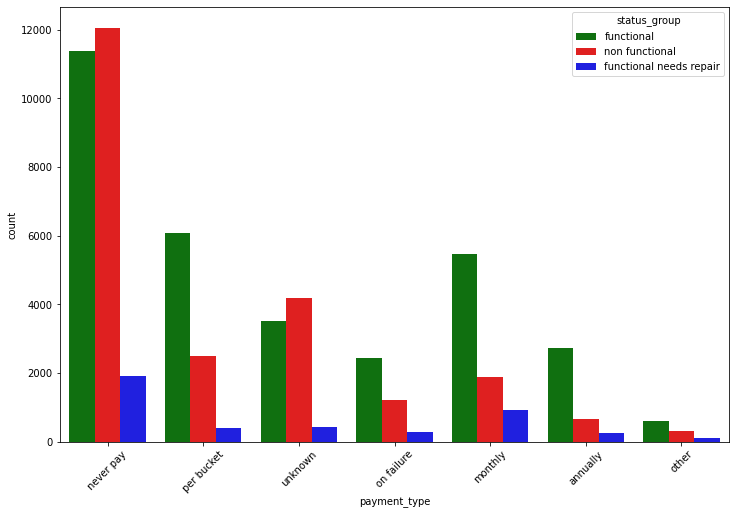

In [30]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(x='payment_type', hue='status_group', data= df, ax=ax, palette= color_status)
plt.xticks(rotation= 45)

on remarque que les puits qui sont payé annuellement , mensuellement ou par bucket sont bien mieux que ceux qui ne sont pas payés 

## la latitude et la longitude de chaque puits sous forme de nuage de points et la couleur  par status (pour montrer l'emplacement de chaque puis et la maniere dont ça fonctionne)

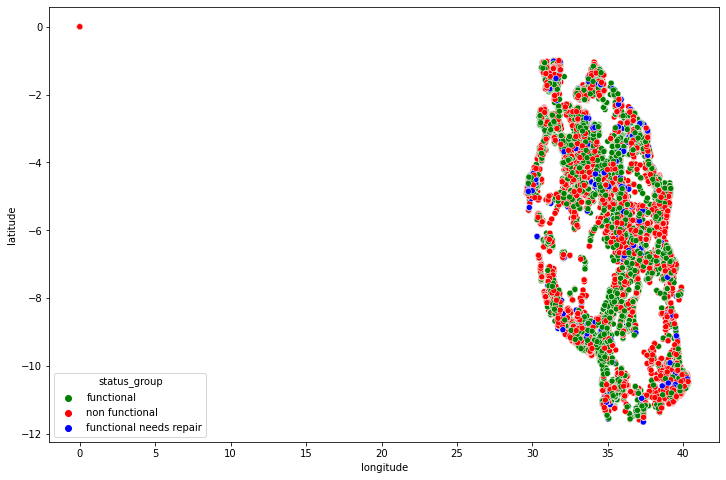

In [31]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x='longitude', y='latitude', data= df,hue='status_group', ax=ax, palette= color_status)

+-------------+--------+
|       region|nb_puits|
+-------------+--------+
|        Rukwa|    1808|
|        Pwani|    2635|
|     Morogoro|    4006|
|         Mara|    1969|
|      Singida|    2093|
|       Kagera|    3316|
|       Dodoma|    2201|
|    Shinyanga|    4982|
|       Tabora|    1959|
|       Arusha|    3350|
|        Lindi|    1546|
|      Manyara|    1583|
|       Ruvuma|    2640|
|Dar es Salaam|     805|
|        Tanga|    2547|
|        Mbeya|    4639|
|       Iringa|    5294|
|  Kilimanjaro|    4379|
|       Mtwara|    1730|
|       Mwanza|    3102|
+-------------+--------+
only showing top 20 rows

+-------------+----------------+
|       region|population_total|
+-------------+----------------+
|        Rukwa|          785528|
|     Morogoro|         1249052|
|        Pwani|         1279056|
|      Singida|          852644|
|         Mara|         1072843|
|       Kagera|         1170673|
|       Dodoma|          711805|
|    Shinyanga|         1750482|
|       Tab

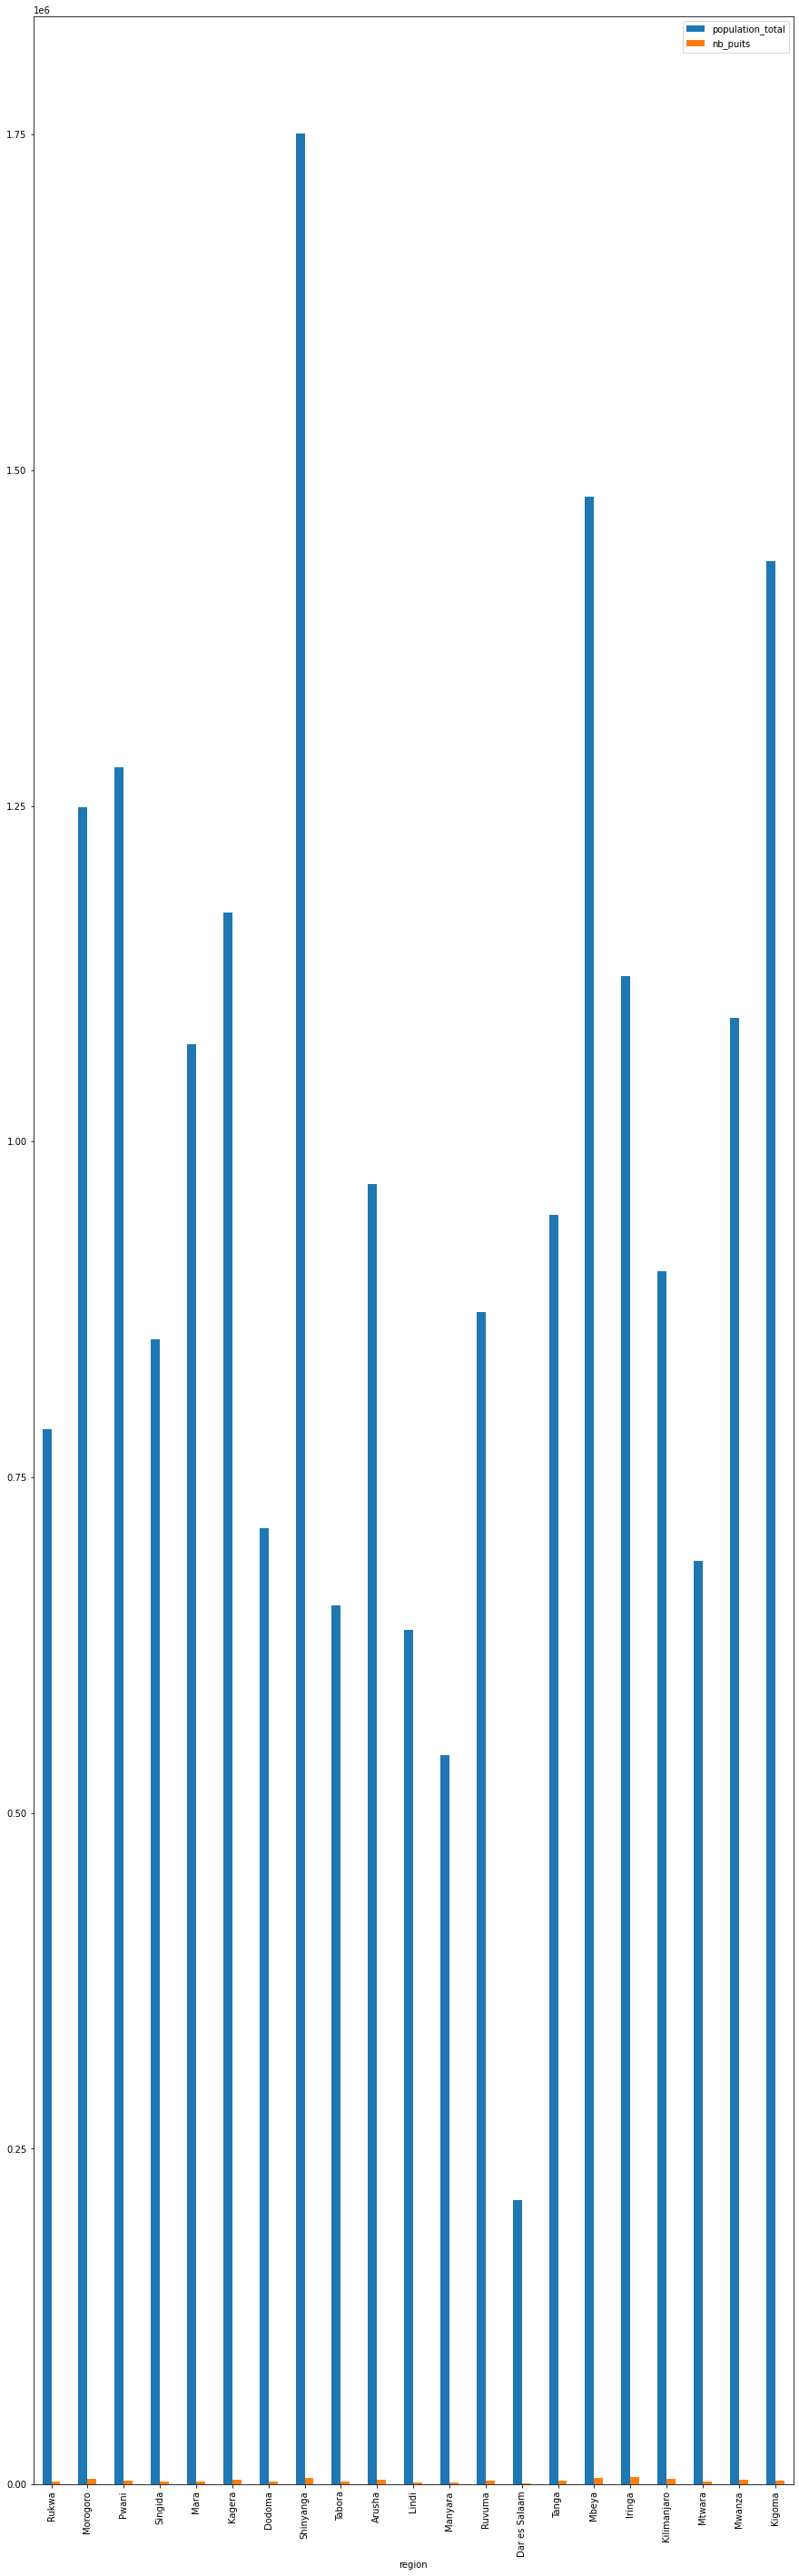

In [32]:

data_region_puit = data.groupBy("region").agg(count("status_group").alias('nb_puits'))
data_region_puit.show()

""" Dataframe du nombre total d'habitants par région """
data_region_pop = data.groupBy("region").agg(sum("population").alias('population_total'))
data_region_pop.show()

""" Jointure de la dataframe du nombre total de population par région et celle du nombre total de puits par région 
Affichage du nombre total de puits et de populations par région """

data_reg_pop_puit = data_region_pop.join(data_region_puit, on="region")
data_reg_pop_puit.show()
data_reg_pop_puit_df = data_reg_pop_puit.toPandas()

data_reg_pop_puit_df.plot.bar(x='region', y=["population_total", "nb_puits"], rot=90, figsize=(15, 50))
plt.savefig('population_well_total_per_region.png')


## histogramme avec des estimations de densité de noyau de la colonne GPS_height (qui indique l'altitude du puits)

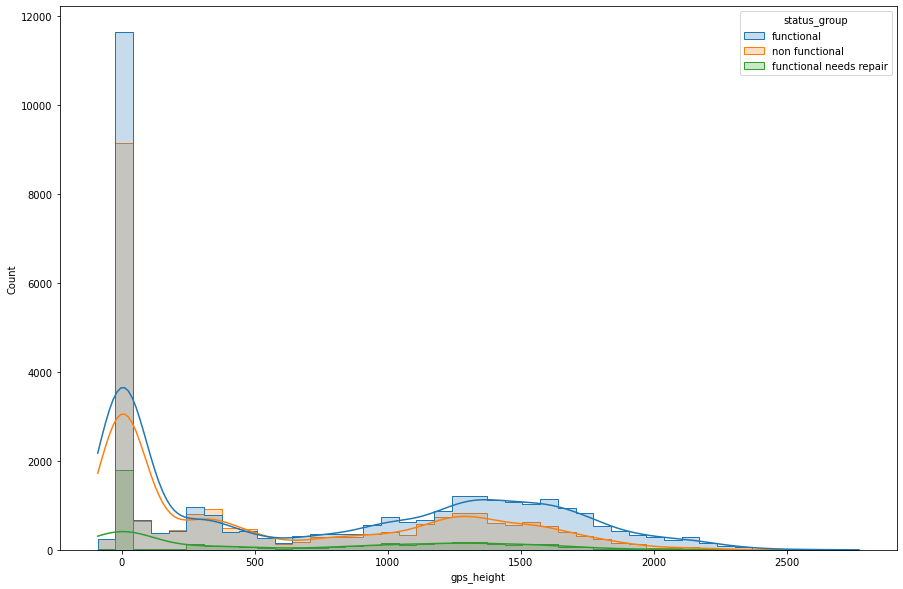

In [33]:
# distplot pour chaque subset utilisant la colonne GPS_height et le meme code de couleur

col = 'gps_height'
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.histplot(data=df, x='gps_height', hue='status_group', element="step", ax=ax, kde=True)
fig.savefig('show_gps_height.png')

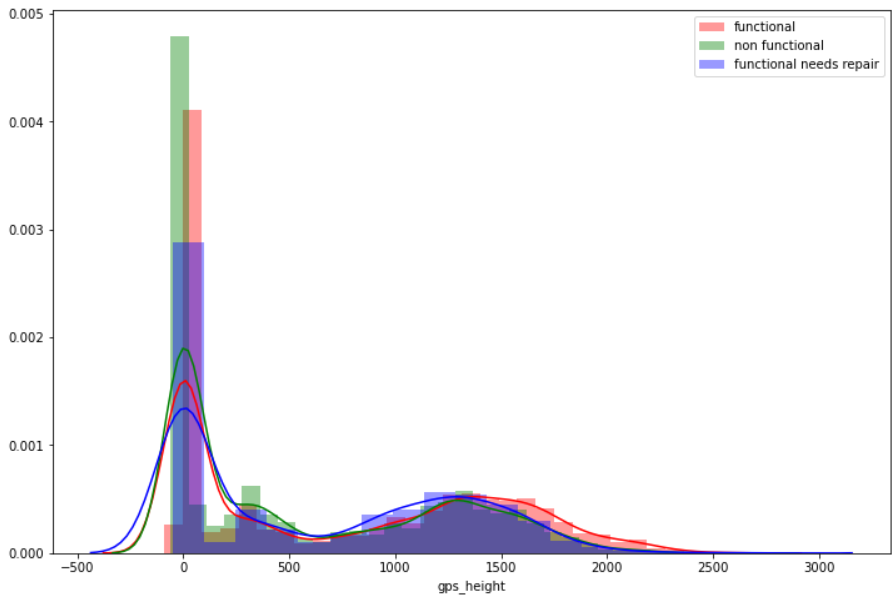

on remarque  qu'en général, les puits à basse altitude sont
plus fonctionnel que les puits à plus haute altitude.


In [34]:

# define the world map centered around with a higher zoom level
# map_draw = folium.Map(location=[-3.852983, 36.756231], tiles='Stamen Toner', zoom_start=11.5)

# loop through the 100 crimes and add each to the incidents feature group
# for index, row in df[df['longitude'].notnull()].iterrows():
    # element raduis
#     elem_radius = round(((row['gps_height'] * 50) / max(df['gps_height'])), 2)

    # element opacity
#     elem_opac = round((elem_radius / 50), 1)

#     lat = row['latitude']
#     longi = row['longitude']
#     folium.CircleMarker(
#         location=[lat, longi],
#         color='#3186cc',
#         fill=True,
#         radius=elem_radius,
#         fill_color='#3186cc',
#         fill_opacity=elem_opac,
#         popup="Status Group: " + str(row['status_group']) + "\nGPS Height: " + str(row['gps_height'])
#     ).add_to(map_draw)

# display world map
# map_draw.save("map_draw.html")

comme on peut remarquer sur la carte ...

Graph des constructions selon les années

+-----------------+---------------+
|construction_year|nb_construction|
+-----------------+---------------+
|                0|          20709|
|             1960|            102|
|             1961|             21|
|             1962|             30|
|             1963|             85|
|             1964|             40|
|             1965|             19|
|             1966|             17|
|             1967|             88|
|             1968|             77|
|             1969|             59|
|             1970|            411|
|             1971|            145|
|             1972|            708|
|             1973|            184|
|             1974|            676|
|             1975|            437|
|             1976|            414|
|             1977|            202|
|             1978|           1037|
+-----------------+---------------+
only showing top 20 rows



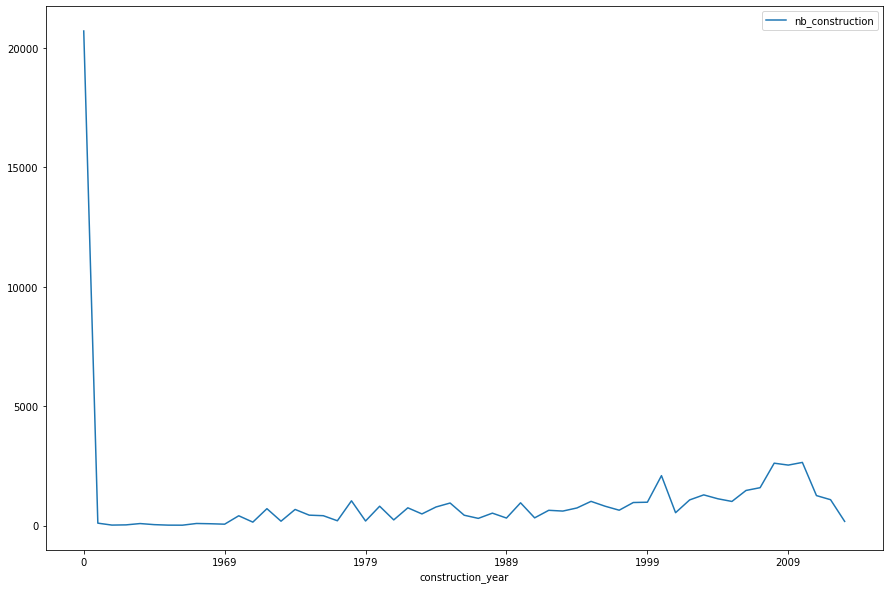

In [42]:
""" Nombre de construction de puits par année """

cons_puit_per_year = data.groupBy("construction_year").agg(count("construction_year").alias("nb_construction"))
# Tri de la colonne 'nb_construction' par ordre croissant
cons_puit_per_year = cons_puit_per_year.sort("construction_year")
cons_puit_per_year.show()

# Transformation du type de la colonne 'construction_year' en string pour un meilleur affichage sur le graphe
cons_puit_per_year_str = cons_puit_per_year.withColumn('construction_year', cons_puit_per_year['construction_year'].cast(StringType()))
# Converstion de la dataframe en dataframe Pandas
cons_puit_per_year_df = cons_puit_per_year_str.toPandas()
cons_puit_per_year_df.plot(x="construction_year", y="nb_construction", figsize=(15, 10))
plt.savefig('well_contruct_over_year.png')

In [43]:
"""" Nombre total de puits par region """
data_region_puit = data.groupBy("region").agg(count("status_group").alias('nb_puits'))
data_region_puit.show()

+-------------+--------+
|       region|nb_puits|
+-------------+--------+
|        Rukwa|    1808|
|        Pwani|    2635|
|     Morogoro|    4006|
|         Mara|    1969|
|      Singida|    2093|
|       Kagera|    3316|
|       Dodoma|    2201|
|    Shinyanga|    4982|
|       Tabora|    1959|
|       Arusha|    3350|
|        Lindi|    1546|
|      Manyara|    1583|
|       Ruvuma|    2640|
|Dar es Salaam|     805|
|        Tanga|    2547|
|        Mbeya|    4639|
|       Iringa|    5294|
|  Kilimanjaro|    4379|
|       Mtwara|    1730|
|       Mwanza|    3102|
+-------------+--------+
only showing top 20 rows



In [44]:
""" Dataframe du nombre total d'habitants par région """
data_region_pop = data.groupBy("region").agg(sum("population").alias('population_total'))
data_region_pop.show()

+-------------+----------------+
|       region|population_total|
+-------------+----------------+
|        Rukwa|          785528|
|     Morogoro|         1249052|
|        Pwani|         1279056|
|      Singida|          852644|
|         Mara|         1072843|
|       Kagera|         1170673|
|       Dodoma|          711805|
|    Shinyanga|         1750482|
|       Tabora|          654451|
|       Arusha|          968310|
|        Lindi|          636403|
|      Manyara|          542746|
|       Ruvuma|          873134|
|Dar es Salaam|          211892|
|        Tanga|          945245|
|        Mbeya|         1480335|
|       Iringa|         1123075|
|  Kilimanjaro|          903715|
|       Mtwara|          687831|
|       Mwanza|         1092233|
+-------------+----------------+
only showing top 20 rows



In [63]:
""" Dataframe to get a geographic location of each region """
data_region = data.select("region", "latitude", "longitude")
w2 = Window.partitionBy("region").orderBy(["latitude", "longitude"])
data_reg_lat_long = data_region.withColumn("row", row_number().over(w2)).filter("row == 1").drop("row")
data_reg_lat_long.show()

+-------------+------------+-----------+
|       region|    latitude|  longitude|
+-------------+------------+-----------+
|       Arusha| -3.76660778|36.42121872|
|Dar es Salaam| -7.16292054|39.50520515|
|       Dodoma| -7.30048157|36.51640562|
|       Iringa|-10.52471048|34.62015406|
|       Kagera| -3.29714898|31.47118963|
|       Kigoma| -5.41675623|29.75061904|
|  Kilimanjaro| -4.60694013|37.99769612|
|        Lindi|-10.63998728|38.11158716|
|      Manyara| -5.95285449|36.87087236|
|         Mara|  -2.4426193|34.81028576|
|        Mbeya| -9.70096514|33.91551046|
|     Morogoro| -9.19142362| 35.9985833|
|       Mtwara|-11.36697424|38.44130523|
|       Mwanza| -3.42444366|33.09599958|
|        Pwani| -8.47755516|38.54411963|
|        Rukwa| -8.99032099|32.09569724|
|       Ruvuma|-11.64944018|37.35113776|
|    Shinyanga| -4.38194618|32.31007456|
|      Singida| -6.94745728|33.52027067|
|       Tabora| -6.91683005|33.46735982|
+-------------+------------+-----------+
only showing top

+-------------+----------------+--------+------------+-----------+
|       region|population_total|nb_puits|    latitude|  longitude|
+-------------+----------------+--------+------------+-----------+
|        Rukwa|          785528|    1808| -8.99032099|32.09569724|
|     Morogoro|         1249052|    4006| -9.19142362| 35.9985833|
|        Pwani|         1279056|    2635| -8.47755516|38.54411963|
|      Singida|          852644|    2093| -6.94745728|33.52027067|
|         Mara|         1072843|    1969|  -2.4426193|34.81028576|
|       Kagera|         1170673|    3316| -3.29714898|31.47118963|
|       Dodoma|          711805|    2201| -7.30048157|36.51640562|
|    Shinyanga|         1750482|    4982| -4.38194618|32.31007456|
|       Tabora|          654451|    1959| -6.91683005|33.46735982|
|       Arusha|          968310|    3350| -3.76660778|36.42121872|
|        Lindi|          636403|    1546|-10.63998728|38.11158716|
|      Manyara|          542746|    1583| -5.95285449|36.87087

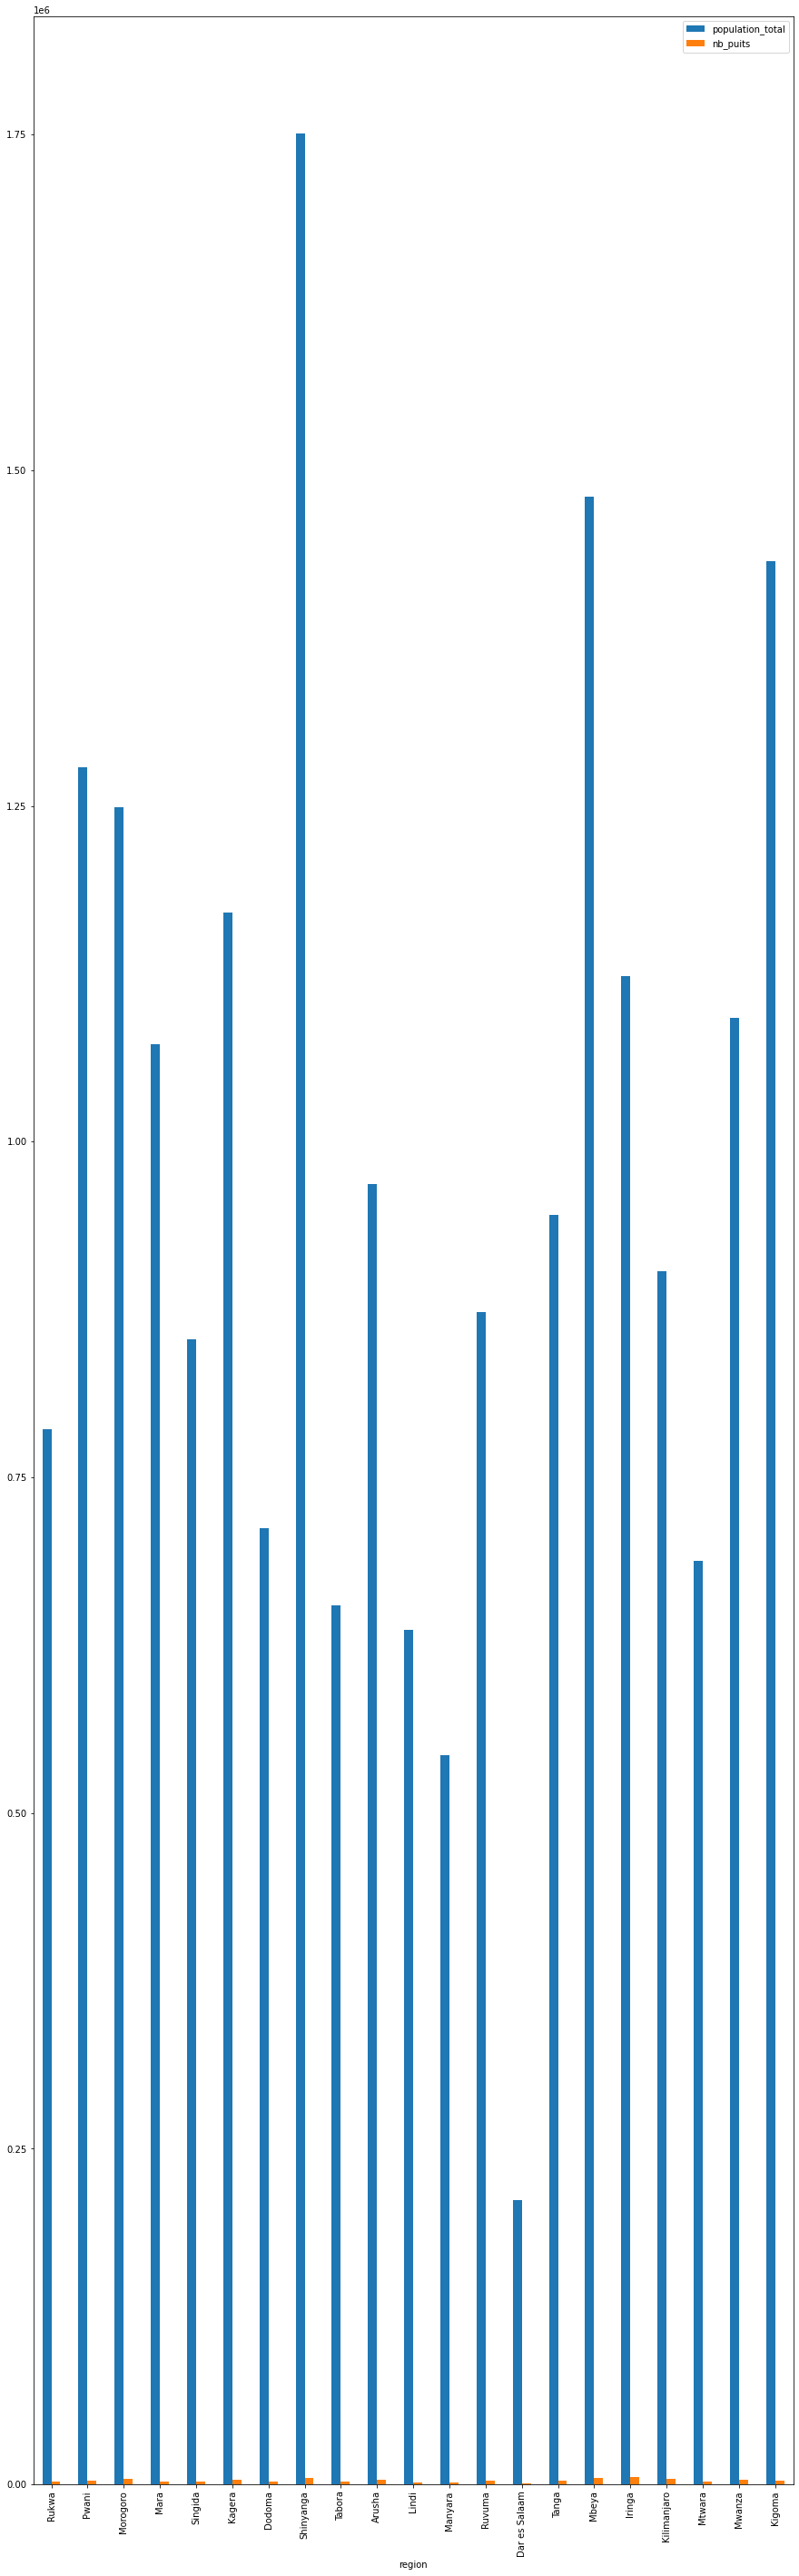

In [64]:
""" Jointure de la dataframe du nombre total de population par région et celle du nombre total de puits par région 
Affichage du nombre total de puits et de populations par région """
data_reg_pop_puit = data_region_pop.join(data_region_puit, on="region").join(data_reg_lat_long, on="region")
data_reg_pop_puit.show()
data_reg_pop_puit_df = data_reg_pop_puit.toPandas()

data_reg_pop_puit_df.plot.bar(x='region', y=["population_total", "nb_puits"], rot=90, figsize=(15, 50))
plt.savefig('population_well_total_per_region.png')

In [65]:
# define the world map centered around Tanzania with a higher zoom level
map_draw1 = folium.Map(location=[data_reg_pop_puit_df['latitude'].mean(), data_reg_pop_puit_df['longitude'].mean()],
                       tiles='Stamen Toner', zoom_start=7)

# loop through the 100 crimes and add each to the incidents feature group
for index, row in data_reg_pop_puit_df[data_reg_pop_puit_df['longitude'].notnull()].iterrows():
    # Population raduis
    pop_radius = round(((row['population_total'] * 50) / data_reg_pop_puit_df['population_total'].max()), 2)
    # Population opacity
    pop_opac = 0.5

    # Well raduis
    well_radius = round(((row['nb_puits'] * 50) / data_reg_pop_puit_df['nb_puits'].max()), 2)
    # Well opacity
    well_opac = 0.5

    lat = row['latitude']
    longi = row['longitude']

    # Add wells point
    folium.CircleMarker(
        location=[lat, longi],
        color='#F50F05',
        fill=True,
        radius=well_radius,
        fill_color='#FCE3E8',
        fill_opacity=well_opac,
        popup="Nombre de puits: " + str(row['nb_puits']) + "\nRegion: " + str(row['region'])
    ).add_to(map_draw1)
    # Add population point
    folium.CircleMarker(
        location=[lat, longi],
        color='#3186cc',
        fill=True,
        radius=pop_radius,
        fill_color='#3186cc',
        fill_opacity=pop_opac,
        popup="Population: " + str(row['population_total']) + "\nRegion: " + str(row['region'])
    ).add_to(map_draw1)
map_draw1

In [66]:
map_draw1.save("map_pop_well_per_region.html")